Step 1: Import libraries & load data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# Load dataset (adjust path if needed)
data = pd.read_csv('covid_19_clean_complete.csv')
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


Step 2: Data cleaning & preprocessing

In [10]:
# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Filter necessary columns
data = data[['Date', 'Province/State', 'Confirmed']]

# Group by date (total cases)
daily_cases = data.groupby('Date')['Confirmed'].sum().reset_index()

# Sort by date
daily_cases = daily_cases.sort_values('Date')

daily_cases.head()


,Date,Confirmed
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118


Step 3: Visualization of cases over time

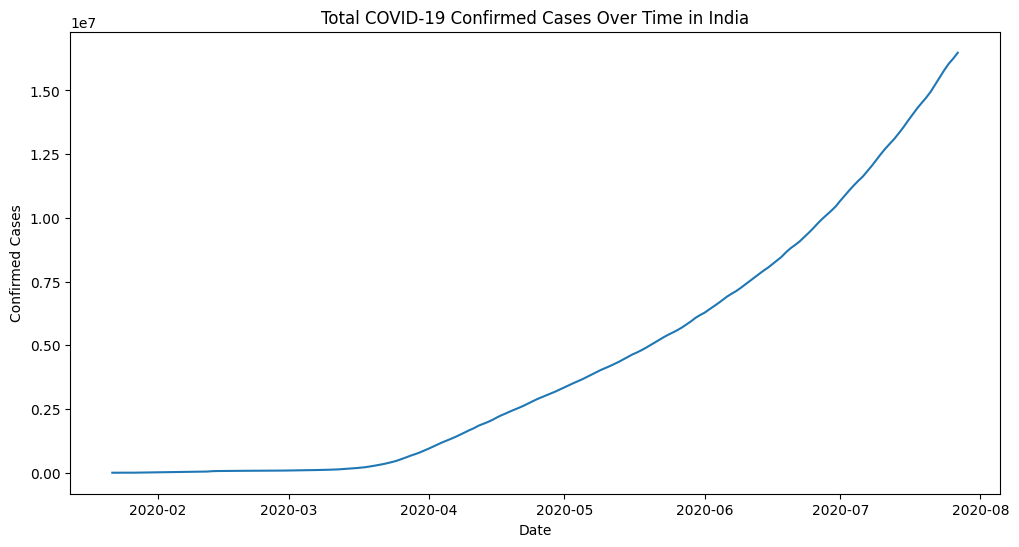

In [11]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Confirmed', data=daily_cases)
plt.title('Total COVID-19 Confirmed Cases Over Time in India')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.show()


Step 4: Prepare data for ML model (Random Forest example)

In [12]:
# Create lag features (e.g., cases 1 day before, 2 days before...)
for i in range(1, 8):
    daily_cases[f'lag_{i}'] = daily_cases['Confirmed'].shift(i)

daily_cases = daily_cases.dropna()

# Define features and target
X = daily_cases.drop(columns=['Date', 'Confirmed'])
y = daily_cases['Confirmed']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Step 5: Train Random Forest model

In [13]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")


RMSE: 4354738.618193366
MAE: 3724956.1232432434


Step 6: Plot actual vs predicted cases

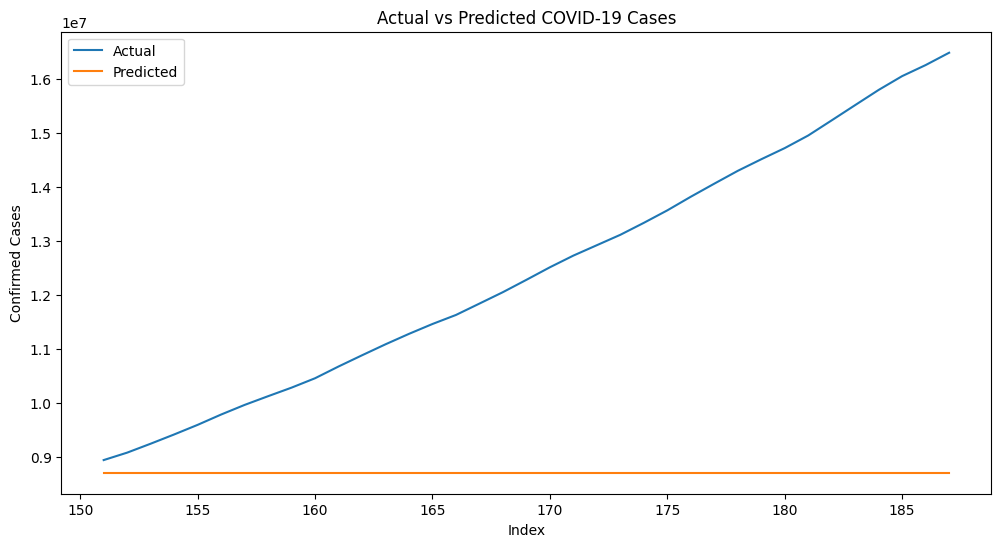

In [14]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted COVID-19 Cases')
plt.xlabel('Index')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()


Step 7: LSTM Time Series Prediction(Long Short-Term Memory networks)   -->deep learning models specialized for time series data, like predicting daily COVID cases.

 1. Preprocess the data for LSTM

In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Use only confirmed case numbers
cases = daily_cases['Confirmed'].values
cases = cases.reshape(-1, 1)

# Normalize the data (LSTM works better with scaled values)
scaler = MinMaxScaler()
cases_scaled = scaler.fit_transform(cases)

# Create time series sequences
sequence_length = 7  # use past 7 days to predict the next day
X = []
y = []

for i in range(sequence_length, len(cases_scaled)):
    X.append(cases_scaled[i-sequence_length:i, 0])
    y.append(cases_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X to fit LSTM input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


2. Build and train the LSTM model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=20, batch_size=16)


c:\Users\sandeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.1455
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0291
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0160
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0036
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.7322e-04
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.4501e-04
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.6921e-04
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4195e-04
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.1267e-04
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.9553e-05
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 7.9268e-05
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.4980e-05
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━

 3. Make predictions

In [17]:
predicted_cases = model.predict(X)
predicted_cases = scaler.inverse_transform(predicted_cases.reshape(-1, 1))

# Actual values
actual_cases = scaler.inverse_transform(y.reshape(-1, 1))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step


4. Plot predicted vs actual cases

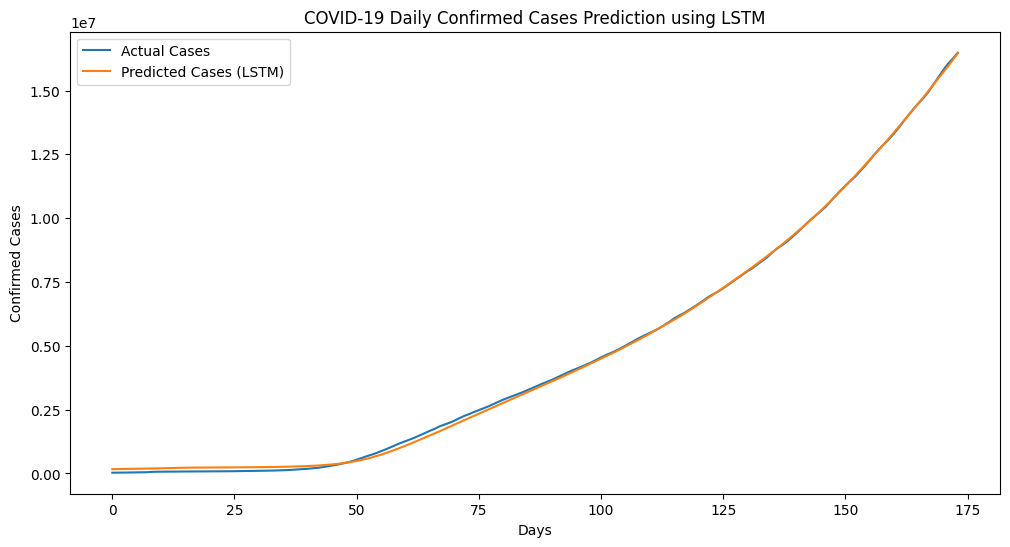

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(actual_cases, label='Actual Cases')
plt.plot(predicted_cases, label='Predicted Cases (LSTM)')
plt.title('COVID-19 Daily Confirmed Cases Prediction using LSTM')
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()


 Step 8: Forecast Future Values (Recursive LSTM Predictions)

In [19]:
future_days = 14  # Change to 7 or any number of days you want to predict

# Start with the last 'sequence_length' days of scaled data
last_sequence = cases_scaled[-sequence_length:].flatten().tolist()

future_predictions = []

for _ in range(future_days):
    # Create the input for prediction
    input_seq = np.array(last_sequence[-sequence_length:]).reshape((1, sequence_length, 1))
    
    # Predict the next value
    next_pred = model.predict(input_seq, verbose=0)[0][0]
    
    # Append the predicted value to the results and the input sequence
    future_predictions.append(next_pred)
    last_sequence.append(next_pred)

# Inverse transform predictions to get actual case numbers
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


Create a timeline for future predictions

In [20]:
# Create future date range
last_date = daily_cases['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Combine into a DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Cases': future_predictions.flatten()})


 Plot past vs future cases

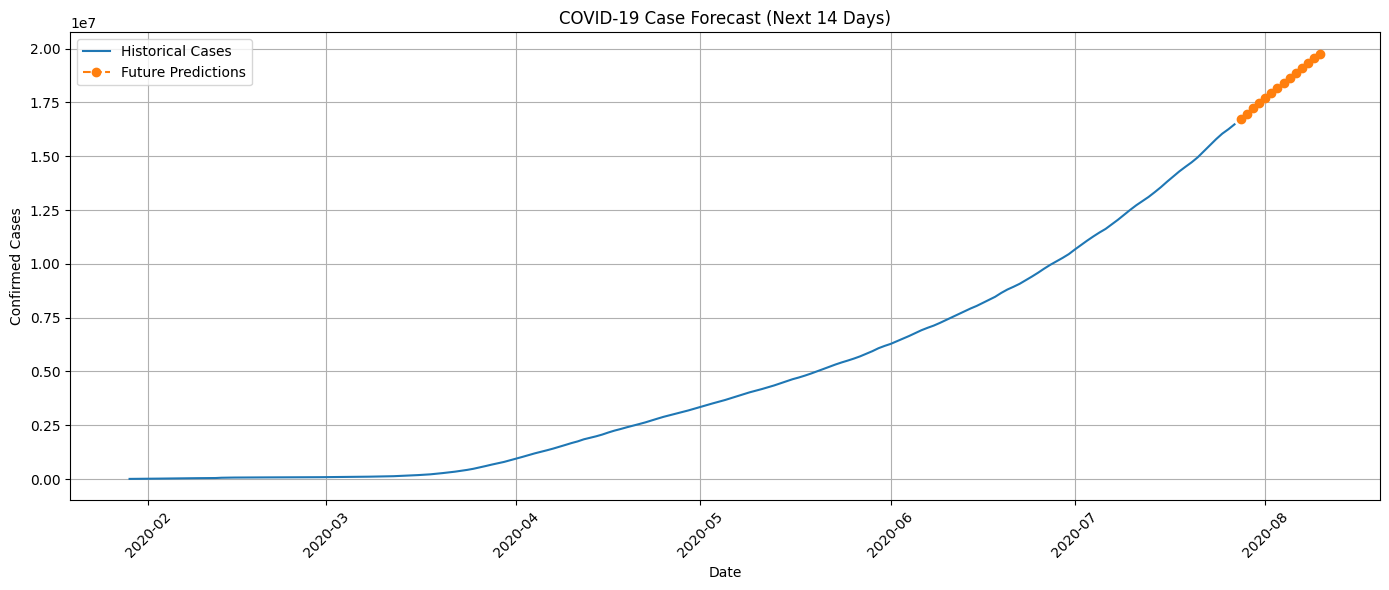

In [21]:
plt.figure(figsize=(14,6))

# Plot past data
plt.plot(daily_cases['Date'], daily_cases['Confirmed'], label='Historical Cases')

# Plot future predictions
plt.plot(future_df['Date'], future_df['Predicted Cases'], label='Future Predictions', linestyle='--', marker='o')

plt.title('COVID-19 Case Forecast (Next 14 Days)')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
